# the dataset

In [21]:
# necessary imports
from fastai.vision.all import *
import hashlib
import os
import pandas as pd

In [2]:
# defining folder structure
ed_folder = 'edible'
ed_file = 'edible_shrooms.txt'

p_folder = 'poisonous'
p_file = 'poison_shrooms.txt'

In [8]:
# creating folders
path = Path('data')
ed_dest = path/ed_folder
ed_dest.mkdir(parents=True, exist_ok=True)
p_dest = path/p_folder
p_dest.mkdir(parents=True, exist_ok=True)

In [9]:
# checking they were created
path.ls()

(#2) [Path('data/edible'),Path('data/poisonous')]

In [11]:
# downloading the images on our txt file
download_images(dest=ed_dest, url_file=Path(ed_file), max_pics=700)
download_images(dest=p_dest, url_file=Path(p_file), max_pics=700)

# at this point I took some time to go over the images and remove stuff that was obviously not supposed to be there, since I have no idea of which mushrooms are actually poisonous and which aren't, that was all I could do.

In [86]:
# we'll try to de-duplicate our dataset with hashes, this is a simple hash, if it's the same image but zoomed out, or rotated, or cropped, it wouldn't work. There are more advanced methods out there but this is fine for our purposes.
hashes = pd.DataFrame([])
for root, dirs, files in os.walk("data"):
    if len(files)>0:
        f = {}
        f['dir'] = root.replace('\\','/')
        f['filename'] = files
        hashes = hashes.append(pd.DataFrame(f),ignore_index=True)

In [87]:
for i,r in hashes.iterrows():
    image_file = open(r['dir'] + '/' + r['filename'],'rb').read()
    hashes.at[i,'hash'] = hashlib.md5(image_file).hexdigest()

In [88]:
# checking the product of our work
hashes.head()

,dir,filename,hash
0,data/edible,00000000.jpg,6029c0ba33d16067d48ccfd417032b49
1,data/edible,00000001.jpg,f148ff2336000bb536b6200a48e9501d
2,data/edible,00000002.jpg,7dd29fdb95fdc8a367050adf2103ed7a
3,data/edible,00000003.jpg,bc3c4fc3367d8855474fee1021c0b311
4,data/edible,00000004.jpg,ac8cfa28f0737006c039ff5f3f76a907


In [89]:
# let's get our duplicates
dups = hashes.duplicated(subset='hash')
dups.value_counts()

False    451
dtype: int64

In [90]:
# delete them if any
for i, r in hashes[dups][['dir','filename']].iterrows():
    os.remove(r['dir'] + '/' + r['filename'])

hashes.drop(hashes[dups].index,inplace=True)

# the model

In [91]:
!pip install --upgrade fastai

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision.all import *
from fastai.vision.data import *
from fastai.metrics import error_rate

In [27]:
# batch size
bs = 32
# seed for some reproducibility
np.random.seed(7)
# we had this before but just in case we are downloading the data and running the model on separate days
path = Path('data')

In [4]:
data = ImageDataLoaders.from_folder(path,item_tfms=[Resize(460)], bs=bs, train='.',valid_pct=.2,num_workers=0,
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

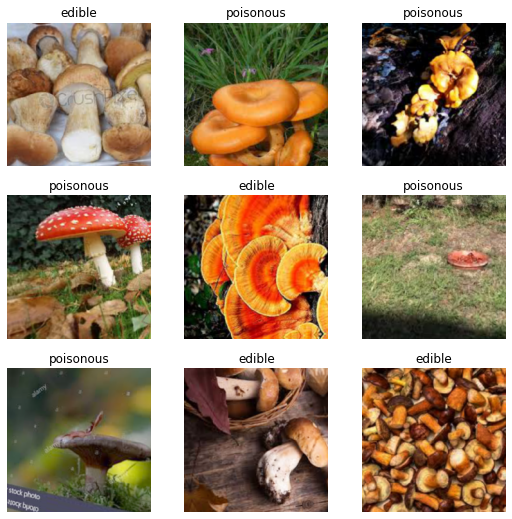

In [131]:
data.show_batch()

In [132]:
print(data.dataset.vocab)
len(data.dataset.vocab),data.c

['edible', 'poisonous']


(2, 2)

In [5]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [140]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.297351,0.687360,0.341176,01:19
1,1.037708,0.556449,0.235294,01:20
2,0.875346,0.667343,0.235294,01:20
3,0.746546,0.728969,0.223529,01:21
4,0.686177,0.678588,0.211765,01:21
5,0.604355,0.661747,0.188235,01:21
6,0.536823,0.663036,0.176471,01:22
7,0.495468,0.679042,0.200000,01:22


In [141]:
learn.save('stage-1')

Path('data/models/stage-1.pth')

In [142]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

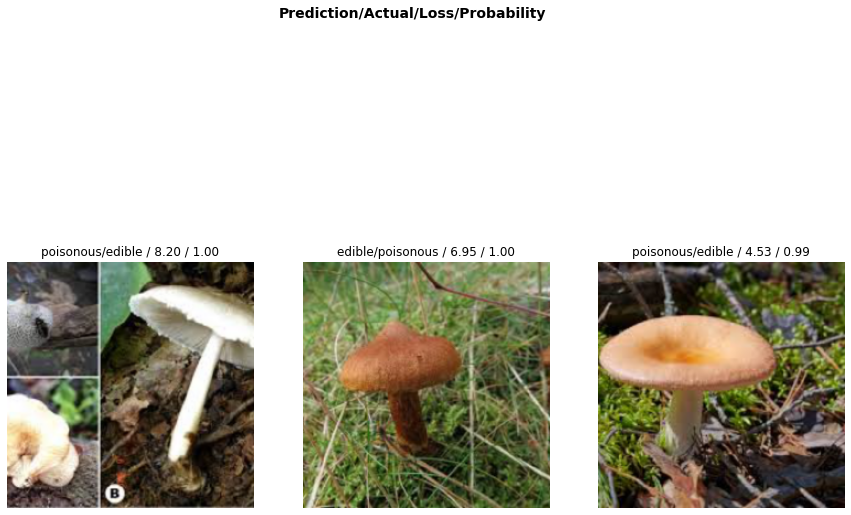

In [143]:
interp.plot_top_losses(3, figsize=(15,11))

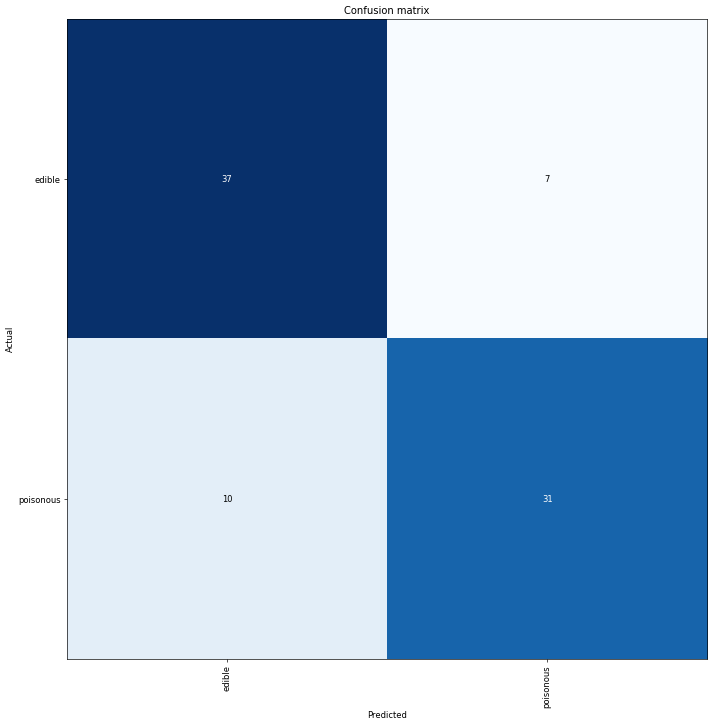

In [144]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [145]:
interp.most_confused(min_val=2)

[('poisonous', 'edible', 10), ('edible', 'poisonous', 7)]

SuggestedLRs(lr_min=0.0006309573538601399, lr_steep=1.0964781722577754e-06)

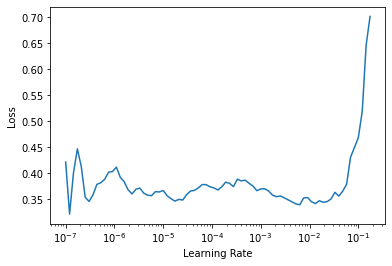

In [146]:
learn.lr_find()

In [152]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(4, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.394323,0.698204,0.200000,01:42
1,0.304993,0.692512,0.200000,01:47
2,0.298229,0.700636,0.211765,01:46
3,0.307053,0.693140,0.223529,01:46


In [155]:
learn.save('stage-2')

Path('data/models/stage-2.pth')

In [156]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

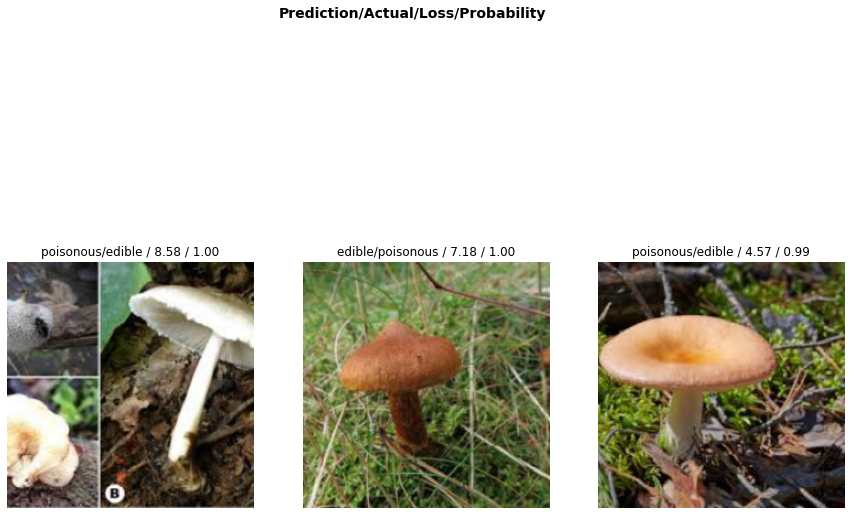

In [157]:
interp.plot_top_losses(3, figsize=(15,11))

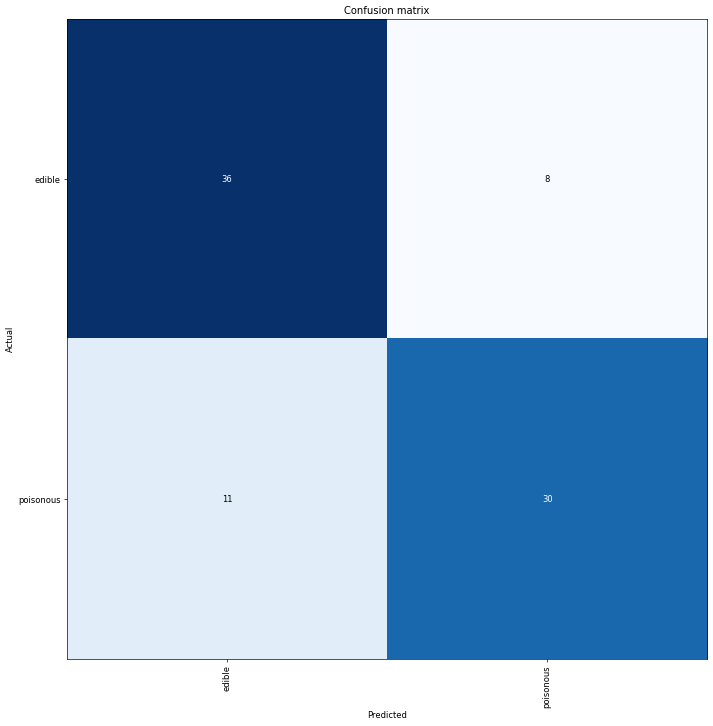

In [158]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [6]:
learn.load('stage-1')
learn.export()

In [19]:
defaults.device = torch.device('cpu')

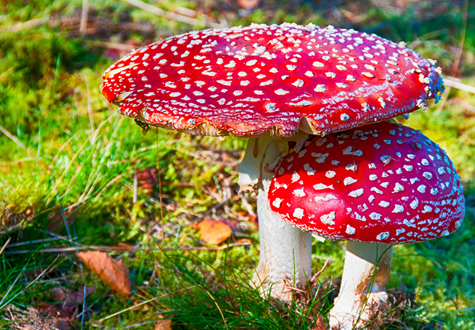

In [35]:
im = PILImage.create('poisonousmushrooms.jpg')
im

In [32]:
learn = load_learner(path/'export.pkl')

In [38]:
pred_class,pred_idx,outputs = learn.predict(im)
pred_class

'poisonous'